# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import ast
from bs4 import BeautifulSoup
import requests
import numpy as np
from multiprocessing import  Pool
from datetime import datetime, timedelta
from collections import namedtuple, Counter
from itertools import combinations
import random
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import math
import warnings # will need this one to suppress some warnings

# this is just a file with a worker function for multiprocessing
# (otherwise multiprocessing doesn't work in Jupyter on Windows)
import worker  

%matplotlib inline
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
RANDOM_SEED = 42

In [3]:
# Helper functions are defined in this cell

'''
# These functions are in worker.py file now
def from_website(url):
    #print(f"https://www.tripadvisor.com{url}")
    r = requests.get(f"https://www.tripadvisor.com{url}", timeout=2)
    soup = BeautifulSoup(r.content)
    
    tmp = soup.find_all('span', {"class":"ratingDate"})
    rev_dates_lst = [i['title'] for i in tmp]
    #rev_dates_lst = [datetime.strptime(i['title'], '%B %d, %Y') for i in tmp]
    
    return rev_dates_lst


def apply_to_dataframe(df):
    df_result = df.copy()
    df_result['all_review_dates'] = df_result['URL_TA'].apply(from_website)
    return df_result
'''

def parallelize_dataframe(df, func, n_cores=30):
    '''
    This function splits the dataframe into the number of chunks
    equal to n_cores (30 by default and that's enough for my PC),
    runs a target function on each parto of the dataframe in parallel
    , concatenates the result into one dataframe and returns it.
    '''
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def create_freq_dict(d):
    '''
    Input dictionary must be sorted!
    
    This function takes dictionary with absolute frequencies as an argument
    and converts it into dictionary with relative frequencies percentages.
    
    For example, dictionary {'$$$$': 1423, '$': 6279, '$$ - $$$': 18412}
    will be turned into {'$$$$': 5.0, '$': 24.0, '$$ - $$$': 71.0}
    '''
    result = d
    tot = np.sum(list(d.values()))
    for k, v in d.items():
        d[k] = round(int(v) / tot * 100,0)
    
    return result


def fill_na_by_frequency(freq_dict, col):
    '''
    This function is used to replace NaN for categorical
    columns with values based on the frequency of non-missing values.

    For this function to work freq_dict (frequency dictionary) should be passed
    as an arguemnt. That's how frequency dictionary might look like (just an example)
    freq_dict: {'other': 7.0, 'father': 24.0, 'mother': 69.0}.
    Numbers correspond to the frequency of every possible distinct value.

    IMPORTANT: this function can't be applied using df.fillna() because the result
    must be different for every row it applies to, whereas fillna() replaces all NaN
    with a single value. Therefore apply() should be used on a column (series)
    '''

    rnd_check = round(random.random()*100)    
    
    cumulative = 0
    for k, v in freq_dict.items():
        # cumulative is used to correctly assess the probability
        # for example, if we take {'other': 7.0, 'father': 24.0, 'mother': 69.0}
        # then "other" will be picked is rnd_check if <= 7, "father" will be
        # picked if rnd_check <= 31 and "mother" will be picked in al the other cases
        cumulative += v
        if rnd_check <= cumulative:
            #print(f'Random number is: {rnd_check}. Value is: {k}')
            return k
    # the last option
    return k
    #print(f'Random number is: {rnd_check}. Value is: {k}')
    
    
def convert_price_range(s):
    '''
    Converts price ranges provided as one of these values
    $
    $$ - $$$            
    $$$$
    to low, average and high 
    '''
    if s == '$':
        return 'low'
    elif s == '$$ - $$$':
        return 'average'
    elif s == '$$$$':
        return 'high'
    else:
        return 'other'

    
def median_interval(l):
    '''
    Takes a list with dates as strings in a format like 'February 28, 2017'
    and returns a median interval between 2 consequent dates in a dataset
    '''   
    #tmp = ast.literal_eval(l)
    tmp = l
    res_lst = []
    if len(tmp) > 1:
        tmp = [datetime.strptime(i, '%B %d, %Y') for i in tmp]
        i = 0
        for d in tmp:
            res_lst.append((tmp[i] - d).days)
        return np.median(res_lst)
    return -1


def restaurant_age(l, snapshot_date):
    '''
    Takes a list with dates as strings in a format like 'February 28, 2017'
    and returns a day difference between snapshot_date and the first review date
    (let's  consider that an estimate of restaurant age on Tripadvisor website)
    '''   
    #tmp = ast.literal_eval(l)
    tmp = l
    res_lst = []
    if len(tmp) > 0:
        tmp = [datetime.strptime(i, '%B %d, %Y') for i in tmp]
        return (snapshot_date - np.min(tmp)).days
    return -1


def is_weekend(l):
    '''
    Takes a list with dates as strings in a format like 'February 28, 2017'
    and returns the most frequent weekday when the review was left
    '''   
    #tmp = ast.literal_eval(l)
    tmp = l
    res_lst = []
    if len(tmp) > 0:
        tmp = [datetime.strftime(datetime.strptime(i, '%B %d, %Y'),'%A') for i in tmp]
        day = Counter(tmp).most_common(1)[0][0]
        if day.lower() in ['saturday','sunday']:
            return 1
        else:
            return -1    
    return -1 


def get_stat_dif(column,  df_data):
    '''
    Student's t-test for all combinations of values for each categorical column
    '''
    cols = df_data.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_data.loc[df_data.loc[:, column] == comb[0], 'Rating'],
                     df_data.loc[df_data.loc[:, column] == comb[1], 'Rating']).pvalue \
                <= 0.05/len(combinations_all):  # Bonferroni correction applied to avoid excessive amount of false negatives
            print('Statistically significant differences found for column:', column)
            return column

        
def show_values(plot):
    '''
    Adds values to bars in bar charts.
    Used only inside other functions 
    that are defined below.
    '''
    for p in plot.patches:
        height = p.get_height()
        if height != 0:
            plot.text(p.get_x()+p.get_width()/2.,
                      height/2 + 0.1, height, ha="center")
        
        
def get_iqr_flexible(s, low_perc=0.25, high_perc=0.75):
    '''
    Returns some basic statistics related to IQR.
    It's flexible because by default this function
    delivers 25, 50, 75 percentiles and IQR, however,
    if you set a different low_perc and high_perc values 
    ther results will be different.

    Of course, if you, for example, set low_perc = 0.1
    and high_perc = 0.9 the result won't actually be IQR
    anymore because it will have nothing to do with quartiles. 
    Name IQR is used here just for convenience and becauss in
    most cases standard will be used anyway.
    '''
    median = s.median()
    iqr = s.quantile(0.75) - s.quantile(0.25)
    perc25 = s.quantile(0.25)
    perc75 = s.quantile(0.75)
    lower_outliers = Counter(s[(s < perc25 - 1.5*iqr)])
    higher_outliers = Counter(s[(s > perc75 + 1.5*iqr)])
    print(
        f'Column name: {s.name}. Median: {median}. Lower percentile ({low_perc}): {perc25}.')
    print(
        f'Higher percentile ({high_perc}): {perc75}. IQR: {iqr}.')
    print(
        f'Lower outliers: {lower_outliers}.')
    print(
        f'Higher outliers: {higher_outliers}.')
    return {'perc25': perc25, 'median': median, 'perc75': perc75, 'iqr': iqr}        


def create_grid(col_list, grid_cols):
    '''
    Creates a grid from the list of given columns
    and a required grid column count. The grid can
    later be used for plotting.

    For example, if a list is 23 item long and
    user wants a grid to be 4 columns wide then
    a grid of 4 columns and 6 rows will be created
    after calling create_grid(col_list, 4)
    '''

    grid_rows = math.ceil(len(col_list) / grid_cols)
    fig, axs = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(25, 25))
    return fig, axs

        
def mass_visualize_grid(var_type, col_list, grid_cols, data_frame):
    '''
    Visualizes all the variables (passed as 
    coll_list) on a grid of a dynamic
    width (controlled using grid_cols argument)
    from the data set (passed as data_frame).

    It's important to pass var_type argument that
    requires one of 2 values: 'cat' for categorical
    and 'num' for numeric variables, because it 
    determines chart type (countplot or distplot)
    '''

    # calling create_grid first
    fig, axs = create_grid(col_list, grid_cols)

    # creating countplots on row and position (pos)
    # that are dynamically calculated
    for i, col in enumerate(col_list):
        row = i // grid_cols
        pos = i % grid_cols

        # if multiple rows in a grid
        if len(axs.shape) > 1:
            ax = axs[row][pos]
        # if only one row in a grid
        else:
            ax = axs[pos]

        if var_type == 'cat':
            # countplot in case of a categorical variable
            plot = sns.countplot(x=col, data=data_frame, ax=ax)
        else:
            # distplot in case of numeric variable
            # ignore filterwarning because if there are no outliers
            # one of the distplot calls below can show a warning
            # and that is OK because there can easily be no outliers
            # to visualize
            warnings.filterwarnings('ignore')
            temp_stats = get_iqr_flexible(data_frame[col], 0.25, 0.75)
            plot = sns.distplot(data_frame[col].loc[data_frame[col].between(
                temp_stats['perc25'] - 1.5*temp_stats['iqr'], temp_stats['perc75'] + 1.5*temp_stats['iqr'])], kde=False, ax=ax, label='Within IQR')
            sns.distplot(data_frame[col].loc[data_frame[col] < (
                temp_stats['perc25'] - 1.5*temp_stats['iqr'])], kde=False, ax=ax, label='Below IQR')
            sns.distplot(data_frame[col].loc[data_frame[col] > (
                temp_stats['perc75'] + 1.5*temp_stats['iqr'])], kde=False, ax=ax, label='Above IQR')
            ax.legend()
            # turning warnings back on
            warnings.filterwarnings('default')

        # adding value counts to bars
        show_values(plot)        

In [4]:
df = pd.read_csv('main_task.xls')
df_small = df.iloc[:240,:] # I sometimes use it for testing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
df.head(10)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681


In [6]:
# Variables Cuisine Style and Reviews are hard to 
# visualize right away - they will be processed later.

# Let's look at City and Price Range to understand if they are 
# significant enough to work with them
for v in ['City','Price Range']:
    get_stat_dif(v, df)

Statistically significant differences found for column: City
Statistically significant differences found for column: Price Range


##### CONCLUSION: It seems that both City and Price range are significant enough to work with them further (target variable average changes significantly depending on predictor variable value). The assumption is that the variables derived from these 2 will also be significant.

City
Amsterdam     4.131215
Athens        4.230096
Barcelona     3.961229
Berlin        4.124594
Bratislava    3.970100
Brussels      3.908962
Budapest      4.090074
Copenhagen    3.985584
Dublin        4.061664
Edinburgh     4.088087
Geneva        3.962578
Hamburg       4.021075
Helsinki      3.946809
Krakow        4.146727
Lisbon        4.046154
Ljubljana     4.112022
London        3.955098
Luxembourg    3.914286
Lyon          3.948430
Madrid        3.800837
Milan         3.824895
Munich        4.047032
Oporto        4.178363
Oslo          3.893506
Paris         3.942414
Prague        4.032571
Rome          4.230269
Stockholm     3.870122
Vienna        4.078045
Warsaw        4.089409
Zurich        4.039963
Name: Rating, dtype: float64


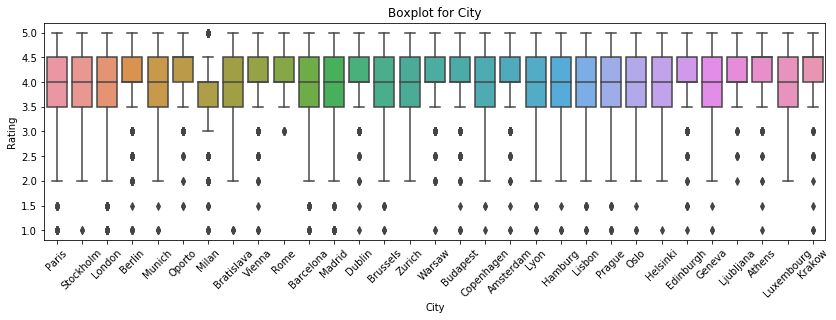

Price Range
average    3.987427
high       4.204849
low        4.092371
other      3.933854
Name: Rating, dtype: float64


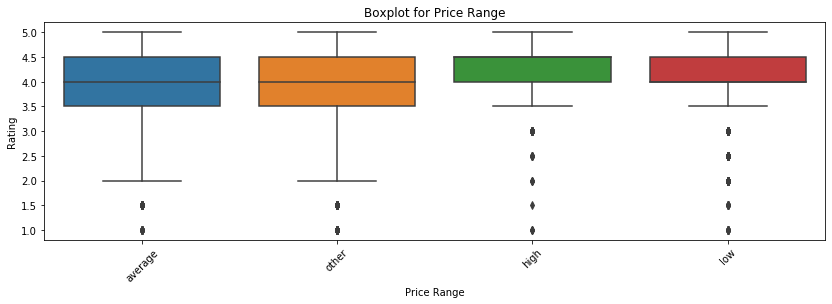

In [7]:
# Let's also assess these variables visually.
# But before that let's convert Price range first
# to make the name more meaningful.
df['Price Range'] = df['Price Range'].map(convert_price_range)

for c in  ['City','Price Range']:
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=c, y=df['Rating'], data=df, ax=ax)
    means = df.groupby(c)['Rating'].mean()
    print(means)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + c)
    plt.show()

Column name: Rating. Median: 4.0. Lower percentile (0.25): 3.5.
Higher percentile (0.75): 4.5. IQR: 1.0.
Lower outliers: Counter({1.0: 201, 1.5: 139}).
Higher outliers: Counter().
Column name: Number of Reviews. Median: 33.0. Lower percentile (0.25): 9.0.
Higher percentile (0.75): 115.0. IQR: 106.0.
Lower outliers: Counter().
Higher outliers: Counter({307.0: 27, 283.0: 23, 377.0: 23, 281.0: 22, 346.0: 21, 297.0: 21, 280.0: 20, 287.0: 19, 277.0: 19, 310.0: 19, 321.0: 18, 383.0: 18, 294.0: 18, 302.0: 17, 303.0: 17, 322.0: 17, 315.0: 17, 343.0: 17, 316.0: 16, 369.0: 16, 335.0: 16, 325.0: 16, 323.0: 16, 327.0: 16, 332.0: 16, 288.0: 15, 278.0: 15, 304.0: 15, 275.0: 15, 333.0: 15, 300.0: 15, 284.0: 15, 311.0: 15, 282.0: 15, 345.0: 14, 472.0: 14, 295.0: 14, 388.0: 14, 324.0: 14, 320.0: 14, 317.0: 14, 362.0: 14, 337.0: 14, 347.0: 14, 299.0: 14, 354.0: 13, 430.0: 13, 366.0: 13, 308.0: 13, 305.0: 13, 433.0: 13, 341.0: 13, 331.0: 13, 357.0: 13, 406.0: 13, 285.0: 13, 363.0: 13, 286.0: 12, 339.0: 1

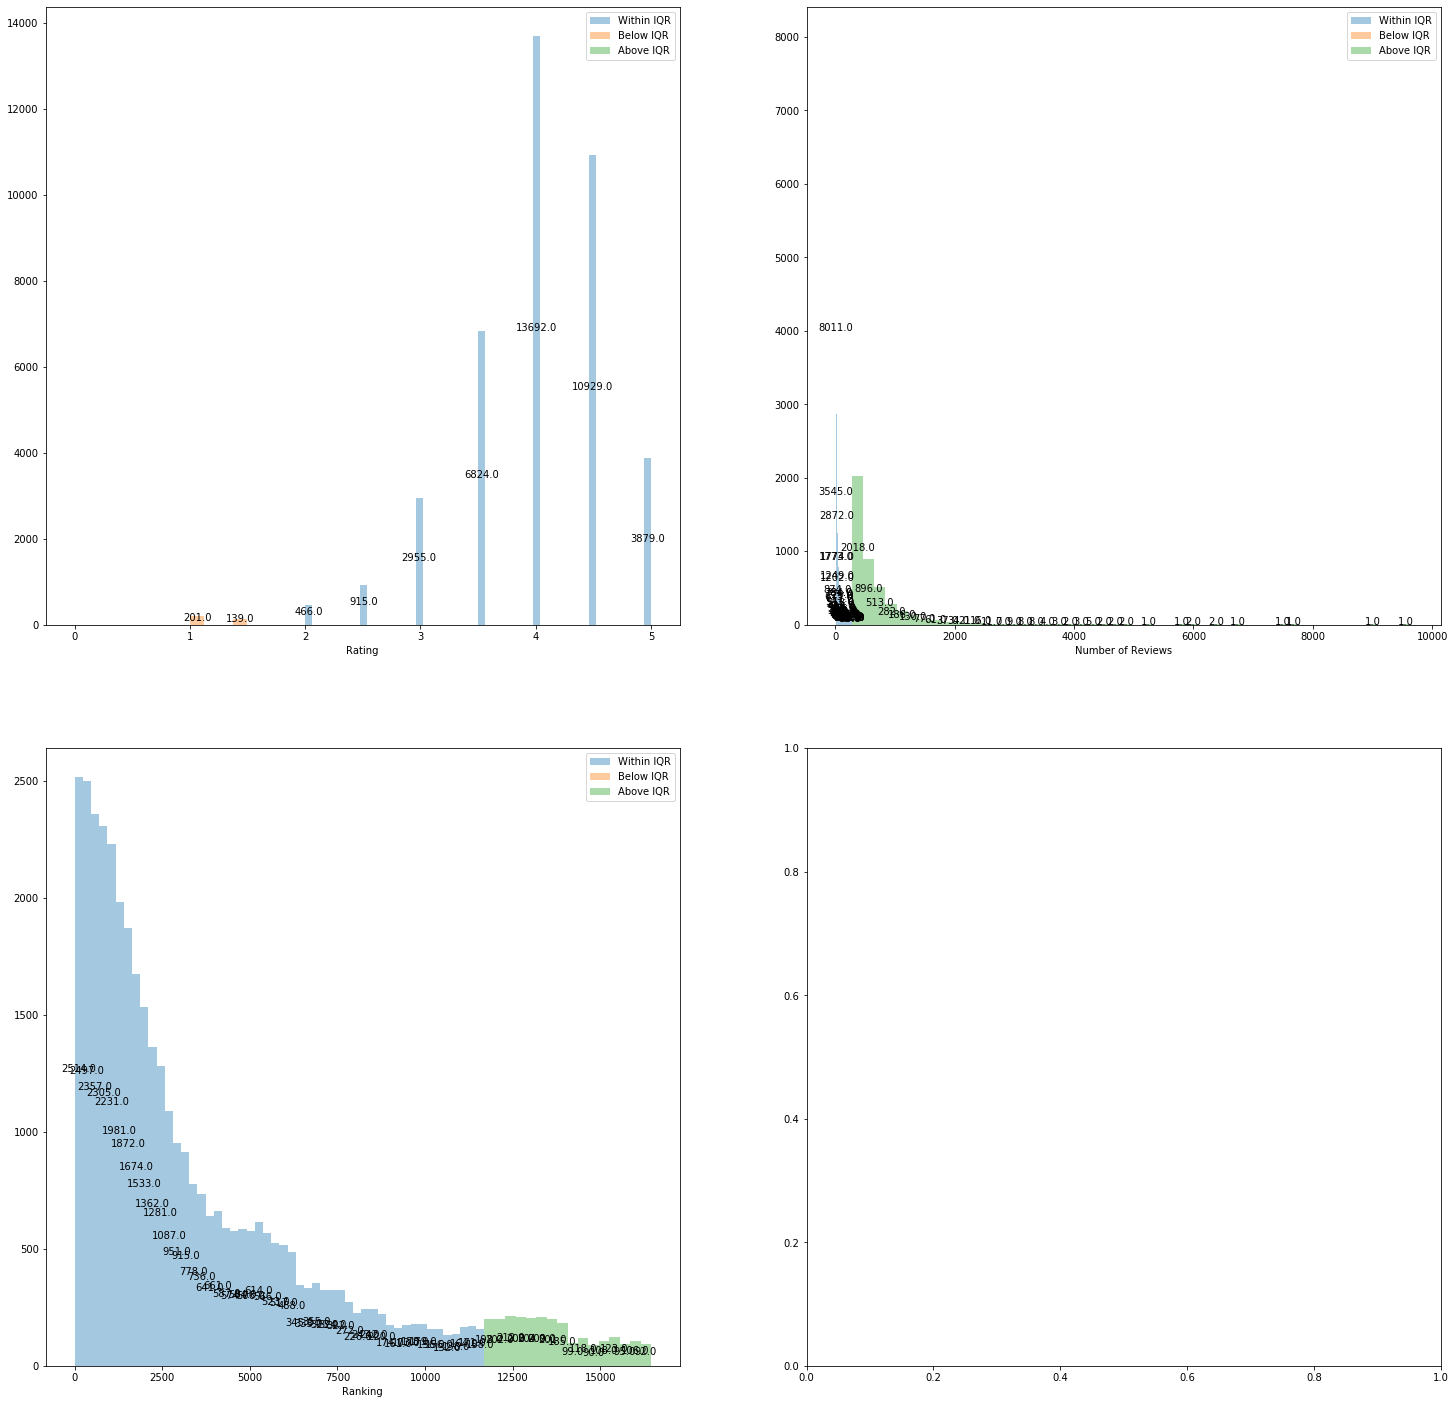

In [8]:
# Let's look at available numeric variables.
# If there's to much text - just scroll down for the visualization.
mass_visualize_grid('num', ['Rating', 'Number of Reviews', 'Ranking'], 2, df)

##### CONCLUSION: Even though mass_visualize_grid shows a lot of outliers for Number of Reviews and Ranking (as well as some for Rating), I don't see the reason whay these values should be excluded from the dataset. They make a perfect business sense. Therefore I won't trust my own visualization.

In [9]:
# This cell is either for crawling tripadvisor website and saving the 
# data to CSV (uncomment a correspondinf section of the code to do it)
# or for reading the CSV file if it has already been created.

'''
# Uncomment it only if you need to crawl Tripadvisor website once again
# Please note that it takes around 2-3 hours (depending on the machine)
# to perform the crawling
if __name__ ==  '__main__': 
    df_crawled = parallelize_dataframe(df, worker.apply_to_dataframe)
    
df_crawled.to_csv('with_additional_data_from_TA_ALL_2.csv')    
'''

# this is a file that consists of an original dataframe 
# extended with additional data from Tripadvisor website
# using requests and beautifulsoup
df = pd.read_csv('with_additional_data_from_TA_ALL_2.csv')
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,all_review_dates
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"['February 14, 2020', 'December 20, 2019', 'No..."
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,[]
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"['September 25, 2020', 'September 5, 2020', 'A..."
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,[]
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"['September 10, 2020', 'September 28, 2019', '..."


In [10]:
# Given the fact that it's currently year 2020 and a dataset for the task contains
# an older data it would be wise to avoid using records that appeared after a maximal
# date available in this dataset (the ones I obtained using web crawling).
# Let's find this date
df['tst'] = df['Reviews'].map(lambda x: x.split("], [")[1])
df['tst'] = df['tst'].str.replace('[','').str.replace(']','').str.replace("'",'').str.replace("'",'').str.split(',')
task_snapshot_date = pd.to_datetime(df['tst'].explode()).max()
df.drop(labels=['tst'], axis=1, inplace=True)
print(f"Snapshot date: {task_snapshot_date}")

Snapshot date: 2018-02-26 00:00:00


In [11]:
# The data was saved to a file after web crawler (function from_website) was executed.
# It means that all_review_dates contains a string representation of a list.
# Let's convert it into the list to make other functions run faster
df['all_review_dates'] = df['all_review_dates'].map(ast.literal_eval)

# Let's remove all the review dates after task_snapshot_date
df['all_review_dates'] = df['all_review_dates'].map(lambda lst:\
    [i for i in lst if task_snapshot_date >= datetime.strptime(i, '%B %d, %Y')])

In [12]:
# let's drop Restaurant_id, ID_TA and URL_TA because we don't need them anymore
df.drop(labels=['Restaurant_id', 'ID_TA','URL_TA'], axis=1, inplace=True)
df.head(5)

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,all_review_dates
0,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...","[January 13, 2018, December 31, 2017, November..."
1,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",[]
2,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...","[May 12, 2014, May 6, 2014, May 5, 2014, May 4..."
3,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",[]
4,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...","[November 18, 2017, July 25, 2017, May 16, 201..."


In [13]:
# let's create 2 simple columns to mimic a basic sentiment analysis
# first column will be 1 if a restaurant contains some negative review
# (like bad, awful, horrible, dirty, disgusting) in 2 reviews provided
# in a dataset
bad_words = "terrible|very bad|awful|horrible|dirty|disgusting|bad experience|don't go|bad service|unfriendly|not good|"\
    "disappointed|rubbish|average food|bad customer service|poor"
df['contains_bad_review'] = df['Reviews'].str.contains(bad_words, regex=True, case=False).astype(int)

# same but with good words 
good_words = "good|nice|amazing|best|great|excellent"
df['contains_good_review'] = df['Reviews'].str.contains(good_words, regex=True, case=False).astype(int)

df.head()

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,all_review_dates,contains_bad_review,contains_good_review
0,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...","[January 13, 2018, December 31, 2017, November...",0,1
1,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",[],0,0
2,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...","[May 12, 2014, May 6, 2014, May 5, 2014, May 4...",0,0
3,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",[],0,0
4,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...","[November 18, 2017, July 25, 2017, May 16, 201...",0,1


In [14]:
df[['contains_bad_review','contains_good_review']].sum()

contains_bad_review      1498
contains_good_review    21001
dtype: int64

In [15]:
# there are some cases when no reviews are given in a list - let's mark them
df['no_reviews_in_list'] = (df['Reviews'] == "[[], []]").astype(int)

In [16]:
# let's process dates available in 'Reviews' column
df['tst'] = df['Reviews'].map(lambda x: x.split("], ["))
df['dates'] = df['tst'].map(lambda x : x[1]).str.replace('[','').str.replace(']','').str.replace("'",'').str.split(',')
df['dates'] = df['dates'].map(lambda x: x if len(x) < 2 else [datetime.strptime(i.strip(), '%m/%d/%Y') for i in x])
# let's create a variable that stores number of days since TripAdvisor website creation (2004-02-01) up to the most recent comment
# if there's no  date available - mark this column as -1
df['days_since_ta_creation'] = df['dates'].map(lambda x : -1 if len(x) < 2 else (max(x) - datetime.strptime('2004-02-01', '%Y-%m-%d')).days)
# let's create a variable that stores days between comments
df['days_between_comments'] = df['dates'].map(lambda x : -1 if len(x) < 2 else (x[0] - x[1]).days)
df.drop(labels=['tst','dates'], axis=1, inplace=True)

In [17]:
# determining unique cuisine styles and their value counts
# ast.literal_eval is required because lists of styles are
# represented as strings in the dataframe
# IMPORTANT: nan values are replaced by the fake list empty list "[]" for this
# particular part of the task, but that does not happen in place
df['cuisine_styles_num'] = df['Cuisine Style'].fillna("[]").apply(ast.literal_eval).apply(len)

In [18]:
# let's check the number of unique cuisine styles (empty records will be marked as
# a "no_style_provided" in place)
df['Cuisine Style'].fillna("['no_style_provided']", inplace=True)

unique_styles = df['Cuisine Style'].apply(ast.literal_eval).explode()\
    .value_counts(normalize=True)

sum(unique_styles.head(25)), unique_styles.head(25)

(0.8227291793776692,
 Vegetarian Friendly    0.106668
 European               0.095905
 no_style_provided      0.088497
 Mediterranean          0.059840
 Italian                0.056856
 Vegan Options          0.042766
 Gluten Free Options    0.039210
 Bar                    0.031431
 French                 0.030411
 Asian                  0.028705
 Pizza                  0.027160
 Spanish                0.026674
 Pub                    0.023347
 Cafe                   0.022165
 Fast Food              0.016254
 British                0.015206
 International          0.015101
 Seafood                0.014348
 Japanese               0.013957
 Central European       0.013280
 American               0.012536
 Sushi                  0.011020
 Chinese                0.010916
 Portuguese             0.010553
 Indian                 0.009924
 Name: Cuisine Style, dtype: float64)

In [19]:
# Let's take top 25 styles and create binary variables out of them
# (for example, European can be either 0 or 1).
for c in list(unique_styles.head(25).index):
    df[c] = df['Cuisine Style'].str.contains(c, regex=False).astype(int)
df.head(25)

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,all_review_dates,contains_bad_review,contains_good_review,...,British,International,Seafood,Japanese,Central European,American,Sushi,Chinese,Portuguese,Indian
0,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...","[January 13, 2018, December 31, 2017, November...",0,1,...,0,1,0,0,0,0,0,0,0,0
1,Stockholm,['no_style_provided'],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",[],0,0,...,0,0,0,0,0,0,0,0,0,0
2,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...","[May 12, 2014, May 6, 2014, May 5, 2014, May 4...",0,0,...,0,0,0,1,0,0,1,0,0,0
3,Berlin,['no_style_provided'],3458.0,5.0,NaN,3.0,"[[], []]",[],0,0,...,0,0,0,0,0,0,0,0,0,0
4,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...","[November 18, 2017, July 25, 2017, May 16, 201...",0,1,...,0,0,0,0,1,0,0,0,0,0
5,Oporto,['no_style_provided'],1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...","[September 16, 2017, May 31, 2017]",0,1,...,0,0,0,0,0,0,0,0,0,0
6,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...","[January 27, 2018, November 5, 2017, August 4,...",0,1,...,0,0,0,0,0,0,0,0,0,0
7,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",[],0,1,...,0,0,0,0,0,0,0,0,0,0
8,Vienna,['no_style_provided'],2692.0,4.0,NaN,NaN,"[[], []]",[],0,0,...,0,0,0,0,0,0,0,0,0,0
9,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...","[December 24, 2017, November 7, 2017, Septembe...",0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# let's consider NaN in number of reviews as 0
df['Number of Reviews'].fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    40000 non-null  object 
 1   Cuisine Style           40000 non-null  object 
 2   Ranking                 40000 non-null  float64
 3   Rating                  40000 non-null  float64
 4   Price Range             26114 non-null  object 
 5   Number of Reviews       40000 non-null  float64
 6   Reviews                 40000 non-null  object 
 7   all_review_dates        40000 non-null  object 
 8   contains_bad_review     40000 non-null  int32  
 9   contains_good_review    40000 non-null  int32  
 10  no_reviews_in_list      40000 non-null  int32  
 11  days_since_ta_creation  40000 non-null  int64  
 12  days_between_comments   40000 non-null  int64  
 13  cuisine_styles_num      40000 non-null  int64  
 14  Vegetarian Friendly     40000 non-null

In [21]:
df['City'].nunique()

31

In [22]:
# Let's use worldcities dataset from https://www.kaggle.com/viswanathanc/world-cities-datasets
# I want to create 2 dimension from an original 'City' column: capital and  population
df_cities = pd.read_csv('worldcities.csv')

# leaving only required columns from worldcities data set
df_cities = df_cities[['city_ascii','capital','population']]

# the assumption here is that most of the capitals will be listed as primary
# and we don't really care about other classification because the variable will be
# binary in the end (capital = 0 or 1)
df_cities['capital'].fillna('other', inplace=True) 

# the assumption here is that most important cities will have the population
# mentioned in the data set
df_cities['population'].fillna(0, inplace=True)

# leaving only cities with max population - this will eliminate duplicates
# in case multiple cities with the same name exist
df_cities.sort_values(by=['city_ascii','population'], ascending=[True,False], inplace=True)
df_cities.drop_duplicates(subset='city_ascii', keep='first', inplace=True)

# making sure we have no more duplicates
df_cities['city_ascii'].value_counts()

Sentjernej      1
Safonovo        1
Almirante       1
Kendallville    1
Kiruna          1
               ..
Stara Pazova    1
Banlung         1
Tallaght        1
Mbamba Bay      1
Dunwoody        1
Name: city_ascii, Length: 13482, dtype: int64

In [23]:
# modifying 'capital' column to make it binary (if capital then 1 else 0)
df_cities['capital'] = df_cities['capital'].map(lambda x : 1 if x == 'primary' else 0)
df_cities['capital'].value_counts()

0    13275
1      207
Name: capital, dtype: int64

In [24]:
# merging df with df_cities based on city name
df = df.merge(df_cities, how='left', left_on='City', right_on='city_ascii')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    40000 non-null  object 
 1   Cuisine Style           40000 non-null  object 
 2   Ranking                 40000 non-null  float64
 3   Rating                  40000 non-null  float64
 4   Price Range             26114 non-null  object 
 5   Number of Reviews       40000 non-null  float64
 6   Reviews                 40000 non-null  object 
 7   all_review_dates        40000 non-null  object 
 8   contains_bad_review     40000 non-null  int32  
 9   contains_good_review    40000 non-null  int32  
 10  no_reviews_in_list      40000 non-null  int32  
 11  days_since_ta_creation  40000 non-null  int64  
 12  days_between_comments   40000 non-null  int64  
 13  cuisine_styles_num      40000 non-null  int64  
 14  Vegetarian Friendly     40000 non-null

In [25]:
# let's see what cities are missing
df[df['capital'].isna()]['City'].value_counts()

Oporto    513
Name: City, dtype: int64

In [26]:
# it seems that we're missing the data about only one city - Oporto (aka Porto in Portugal)
# let's locate it and populate missing values manually
df['capital'].fillna(0, inplace=True)
df['population'].fillna(1337000, inplace=True)

In [27]:
# let's encode cities
df['City_copy'] = df['City']
df = pd.get_dummies(df, columns=[ 'City_copy',], dummy_na=True)

In [28]:
# let's drop some columns that are not required anymore
# to make the dataframe more compact and readable
df.drop(['city_ascii', 'Cuisine Style', 'Reviews'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 71 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    40000 non-null  object 
 1   Ranking                 40000 non-null  float64
 2   Rating                  40000 non-null  float64
 3   Price Range             26114 non-null  object 
 4   Number of Reviews       40000 non-null  float64
 5   all_review_dates        40000 non-null  object 
 6   contains_bad_review     40000 non-null  int32  
 7   contains_good_review    40000 non-null  int32  
 8   no_reviews_in_list      40000 non-null  int32  
 9   days_since_ta_creation  40000 non-null  int64  
 10  days_between_comments   40000 non-null  int64  
 11  cuisine_styles_num      40000 non-null  int64  
 12  Vegetarian Friendly     40000 non-null  int32  
 13  European                40000 non-null  int32  
 14  no_style_provided       40000 non-null

In [29]:
# let's take a look at price ranges
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [30]:
# it seems there are many NaN values among price ranges
# let's replace NaN with values based on a frequency of the existing values
# custom function will be used for that (see definition of helper functions above)

# please note that ascending=True is important here because the dictionary must be sorted
freq_dict = create_freq_dict(dict(df['Price Range'].value_counts(ascending=True)))
df['Price Range'] = df['Price Range'].apply(
    lambda x: fill_na_by_frequency(freq_dict, "Price Range") if pd.isna(x) else x)
# also let's make Price Range names more meaningful (before we one hot encode them)
df['Price Range'] = df['Price Range'].apply(convert_price_range)

In [31]:
# let's take a look at price ranges once again - it seems that there are
# no more missing values
df['Price Range'].value_counts()

average    28256
low         9551
high        2193
Name: Price Range, dtype: int64

In [32]:
# and there are no more missing values in the dataframe as such
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 71 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    40000 non-null  object 
 1   Ranking                 40000 non-null  float64
 2   Rating                  40000 non-null  float64
 3   Price Range             40000 non-null  object 
 4   Number of Reviews       40000 non-null  float64
 5   all_review_dates        40000 non-null  object 
 6   contains_bad_review     40000 non-null  int32  
 7   contains_good_review    40000 non-null  int32  
 8   no_reviews_in_list      40000 non-null  int32  
 9   days_since_ta_creation  40000 non-null  int64  
 10  days_between_comments   40000 non-null  int64  
 11  cuisine_styles_num      40000 non-null  int64  
 12  Vegetarian Friendly     40000 non-null  int32  
 13  European                40000 non-null  int32  
 14  no_style_provided       40000 non-null

In [33]:
# processing Price Range with one hot encoder
enc = OneHotEncoder(handle_unknown='ignore')
y = OneHotEncoder().fit_transform(df['Price Range'].to_numpy().reshape(-1, 1)).toarray()
# list(df['Price Range'].unique()) is safe because the values are provided 
# in order of appearance
df_price_rng = pd.DataFrame(y, columns=list(df['Price Range'].unique()))
df = pd.concat([df,df_price_rng], axis=1)
df.drop(['Price Range'], inplace=True, axis=1)

In [34]:
# let's calculate restaurant_age for every restaraunt and drop 'all_review_dates' column
df['restaurant_age'] = df['all_review_dates'].map(lambda x: restaurant_age(x, snapshot_date=task_snapshot_date))
# let's calculate median interval between consequetive review dates
df['median_interval'] = df['all_review_dates'].map(median_interval)
# let's determine if most reviews were left on weekend or a weekday
df['is_weekend'] = df['all_review_dates'].map(is_weekend)
df.drop(labels=['all_review_dates'], axis=1, inplace=True)
df.info()
print(f"Most popular restaurant age on a tripadvisor: {df['restaurant_age'].value_counts().index[0]}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 75 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    40000 non-null  object 
 1   Ranking                 40000 non-null  float64
 2   Rating                  40000 non-null  float64
 3   Number of Reviews       40000 non-null  float64
 4   contains_bad_review     40000 non-null  int32  
 5   contains_good_review    40000 non-null  int32  
 6   no_reviews_in_list      40000 non-null  int32  
 7   days_since_ta_creation  40000 non-null  int64  
 8   days_between_comments   40000 non-null  int64  
 9   cuisine_styles_num      40000 non-null  int64  
 10  Vegetarian Friendly     40000 non-null  int32  
 11  European                40000 non-null  int32  
 12  no_style_provided       40000 non-null  int32  
 13  Mediterranean           40000 non-null  int32  
 14  Italian                 40000 non-null

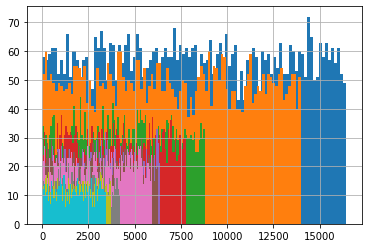

In [35]:
# visual assessment of numeric variables
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [36]:
# let's create a variable that shows if restaraunt is above or below the average Ranking in the city
df['avg_rank_by_city'] = df.groupby('City')['Ranking'].transform(np.mean)
df['better_than_average'] = (df['Ranking'] < df['avg_rank_by_city']).astype(int)

# let's normalize Ranking using count of restaurants in the city
df['cnt_rest_in_the_city'] = df.groupby('City')['City'].transform('count')
df['ranking_norm'] = df['Ranking']/df['cnt_rest_in_the_city']

# let's normalize Ranking using max rank by city
df['max_rank_by_city'] = df.groupby('City')['Ranking'].transform(np.max)
df['ranking_norm_max'] = df['Ranking']/df['max_rank_by_city']

# let's normalize Ranking using count of reviews by city
df['cnt_rev_by_city'] = df.groupby('City')['Number of Reviews'].transform('sum')
df['ranking_norm_reviews'] = df['Ranking']/df['cnt_rev_by_city']

##### Given the fact that Ranking is heavily affected by the size of the city 
##### (therefore by the number of restaurants), Ranking had to be normalized.
###### Below are the results of several normalization attempts.

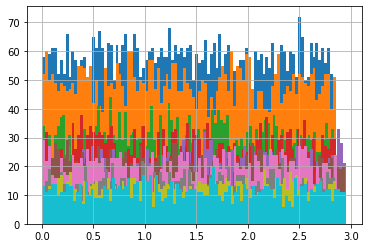

In [37]:
# after dividing by the number of restaurants in the city
for x in (df['City'].value_counts())[0:10].index:
    df['ranking_norm'][df['City'] == x].hist(bins=100)
plt.show()

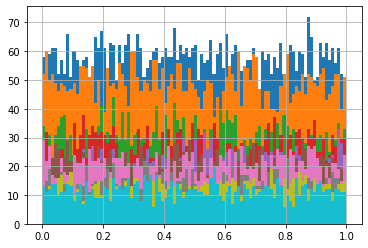

In [38]:
# after dividing by the max Ranking in the city
for x in (df['City'].value_counts())[0:10].index:
    df['ranking_norm_max'][df['City'] == x].hist(bins=100)
plt.show()

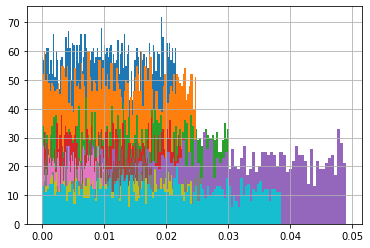

In [39]:
# after dividing by the number of reviews in the city
for x in (df['City'].value_counts())[0:10].index:
    df['ranking_norm_reviews'][df['City'] == x].hist(bins=100)
plt.show()

In [40]:
# let's create a variable that shows number of reviews per 1000 citizens
df['reviews_per_capita'] = df['Number of Reviews']*1000 / df['population']

In [41]:
df.drop(['City', 'avg_rank_by_city', 'cnt_rest_in_the_city', 'cnt_rev_by_city', 'max_rank_by_city'], axis=1, inplace=True)

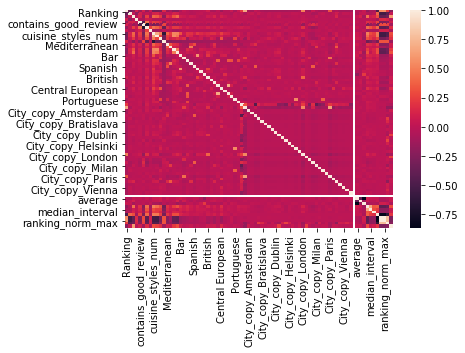

In [42]:
# corellation plot and correlcation matrix
sns.heatmap(df.corr())

In [43]:
df.corr()

,Ranking,Rating,Number of Reviews,contains_bad_review,contains_good_review,no_reviews_in_list,days_since_ta_creation,days_between_comments,cuisine_styles_num,Vegetarian Friendly,...,high,low,restaurant_age,median_interval,is_weekend,better_than_average,ranking_norm,ranking_norm_max,ranking_norm_reviews,reviews_per_capita
Ranking,1.000000,-0.368371,-0.222072,0.107278,-0.143165,0.106386,-0.165798,0.055686,-0.313208,-0.300139,...,-0.035979,0.050479,-0.182420,-0.076365,-0.074827,-0.492492,0.553154,0.572154,0.239557,-0.208348
Rating,-0.368371,1.000000,0.026924,-0.198784,0.108844,-0.024727,0.022657,-0.039875,0.113886,0.128356,...,0.031509,0.041452,-0.047869,-0.060699,-0.008221,0.387430,-0.542702,-0.544573,-0.431821,0.034169
Number of Reviews,-0.222072,0.026924,1.000000,-0.025363,0.120875,-0.163535,0.245805,-0.079108,0.399564,0.364499,...,0.107617,-0.101701,0.434999,0.083676,0.123716,0.301553,-0.406344,-0.406030,-0.349108,0.614718
contains_bad_review,0.107278,-0.198784,-0.025363,1.000000,-0.030715,-0.086654,0.078652,0.044599,-0.033002,-0.050758,...,-0.011643,-0.007624,-0.003580,0.020062,0.005713,-0.112048,0.152796,0.153248,0.121013,-0.018208
contains_good_review,-0.143165,0.108844,0.120875,-0.030715,1.000000,-0.461881,0.443555,0.111346,0.234615,0.204270,...,-0.012839,-0.016852,0.182948,0.135783,0.092547,0.249499,-0.274192,-0.274972,-0.225036,0.084058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
better_than_average,-0.492492,0.387430,0.301553,-0.112048,0.249499,-0.282175,0.408596,-0.080946,0.476546,0.472310,...,0.047198,-0.071336,0.366390,0.219688,0.176825,1.000000,-0.864231,-0.865021,-0.664088,0.204880
ranking_norm,0.553154,-0.542702,-0.406344,0.152796,-0.274192,0.291282,-0.419672,0.099304,-0.543494,-0.548345,...,-0.081517,0.092174,-0.415688,-0.208925,-0.194996,-0.864231,1.000000,0.998945,0.777147,-0.274779
ranking_norm_max,0.572154,-0.544573,-0.406030,0.153248,-0.274972,0.292168,-0.419941,0.098853,-0.543859,-0.549669,...,-0.081180,0.093081,-0.415386,-0.208776,-0.194528,-0.865021,0.998945,1.000000,0.767718,-0.276577
ranking_norm_reviews,0.239557,-0.431821,-0.349108,0.121013,-0.225036,0.250612,-0.376208,0.101414,-0.478416,-0.455864,...,-0.058506,0.043797,-0.369248,-0.199474,-0.188602,-0.664088,0.777147,0.767718,1.000000,-0.224441


##### FINDINGS:

Many of the features are weakly correlated with the target variable. And some of the features correlate with each other. I tried removing some of the weakest features (based on correlation matrix), but doing so decreases the performance of the model. Same goes for correlated features. I have 2 explanations for that:

1) It might be that random forest is not that much affected by predictors that are correlated with each other. In this case the only aspect that suffers is model training time.

2) Some advanced dimesnionality reduction method might help with removal of extra features without affecting the performance, but I don't know this method yet. 

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [44]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
#X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [45]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [46]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [47]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [48]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [49]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1984685


#####  FINAL THOUGHTS:

We can actually leave only top 20 of the most important features.
20 is a number I picked based on multiple iterations.
I know that it won't affect performance, but will at least make a model more compact - this approach can be useful when putting a model to production.

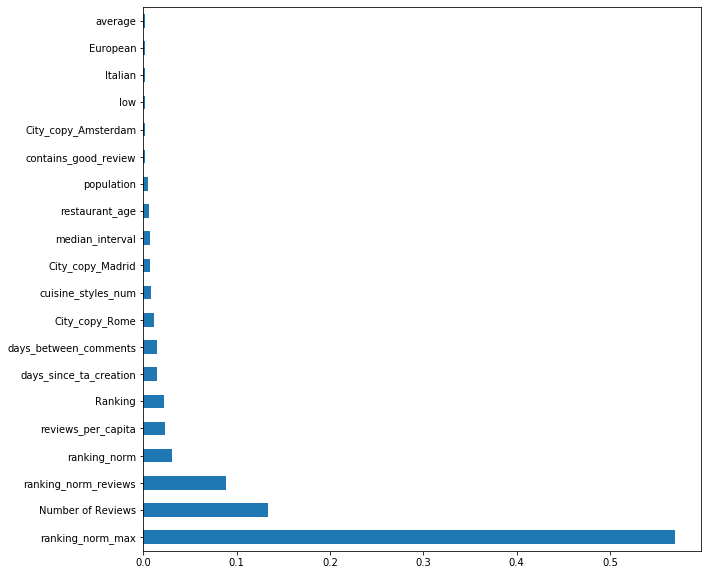

In [50]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')